# 3. hands-on session: **Classification problem: from *Data* to *Inference***

## **Contents**

1. Preprocess the data
1. Select features & reduce dimensions
1. Closs-validate
1. Find best hyperparameters
1. Compare classifiers
1. Combine classifiers
1. Evaluate performance
1. Predict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
!pip install corner
import corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Our dataset**

SDSS data of point sources: stars vs Quasi-stellar objects

<img src="https://cdn.mos.cms.futurecdn.net/HgaCHZDNppE6e52yeDACo6-970-80.jpg.webp" height=200>

<img src="https://earthsky.org/upl/2021/01/supermassive-black-hole-artist-e1610556964639.jpg" height=200 align=right>



# **Sloan Digital Sky Survey (SDSS)**

- photometry & spectroscopy

- fotometry 1 billion objects

- spectroscopy 6 million objects

- stars from our galaxy

- galaxies up to $z \approx 0.7$

- quasars up to $z \approx 6$

- color system `u g r i z`

<img src="https://www.astroml.org/_images/fig_sdss_filters_1.png" align=left width=500>

In [3]:
!wget -c "https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB" -O "sdss_photo.csv"

--2022-10-14 14:50:56--  https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving drive.google.com (drive.google.com)... 108.177.127.139, 108.177.127.102, 108.177.127.100, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/noeqtui396cndevo2796gfkk0un8o0rq/1665759000000/12667160157784747384/*/1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB?uuid=d7247c71-13e1-490d-a47a-4c80c98ded44 [following]
--2022-10-14 14:50:56--  https://doc-04-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/noeqtui396cndevo2796gfkk0un8o0rq/1665759000000/12667160157784747384/*/1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB?uuid=d7247c71-13e1-490d-a47a-4c80c98ded44
Resolving doc-04-2s-docs.googleusercontent.com (doc-04-2s-docs.googleusercontent.com)... 108.177.96.132, 2a00:1450:4013:c06::84
Connecting to do

In [4]:
data = pd.read_csv("sdss_photo.csv")

## **Data preprocessing**

In [5]:
data

,u,g,r,i,z,target
0,19.240999,17.525999,16.840000,16.613001,16.492001,star
1,19.732000,18.339001,17.767000,17.580000,17.481001,star
2,16.120001,15.232000,14.933000,14.845000,14.827000,star
3,18.995001,18.150999,17.877001,17.747000,17.766001,star
4,19.032000,18.112000,17.848000,17.709999,17.712000,star
...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,QSO
863,26.433001,21.429001,20.261000,20.108000,20.073000,QSO
864,20.535999,20.200001,20.292999,19.910000,19.726000,QSO
865,20.627001,20.583000,20.270000,20.229000,20.190001,QSO


In [6]:
data.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,19.29,18.17,17.72,17.54,17.45
std,1.39,1.33,1.35,1.37,1.38
min,15.67,14.36,14.12,13.95,13.89
25%,18.50,17.29,16.74,16.54,16.45
50%,19.33,18.33,17.88,17.69,17.62
75%,20.02,19.09,18.76,18.61,18.52
max,26.43,25.17,21.14,20.72,20.91


In [7]:
sum(data.target== "star"), sum(data.target == "QSO")

(655, 212)

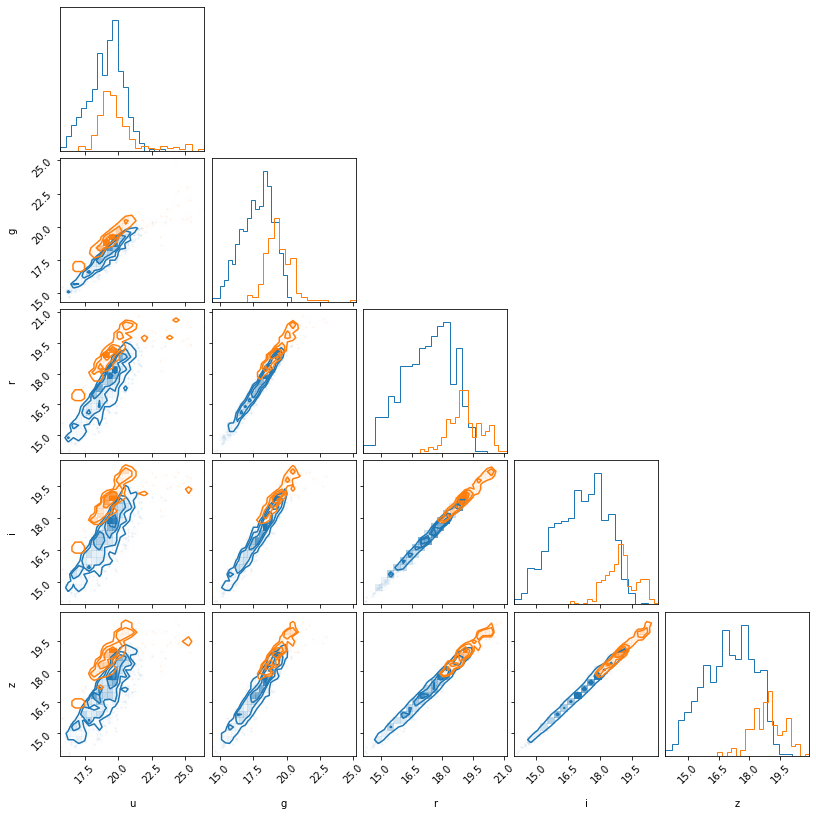

In [8]:
cols = data.columns
fig = corner.corner(data[cols[0:5]][data.target == "star"], color="C0")
corner.corner(data[cols[0:5]][data.target == "QSO"], fig=fig, color="C1");

### task 1: **create `X` and `y`**

```python
data[["u","g","r","i","z"]] -> X
data.target -> y
"QSO" -> 0
"star" -> 1
```

hint: you can use [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


In [9]:
X = data[["u","g","r","i","z"]]
X

,u,g,r,i,z
0,19.240999,17.525999,16.840000,16.613001,16.492001
1,19.732000,18.339001,17.767000,17.580000,17.481001
2,16.120001,15.232000,14.933000,14.845000,14.827000
3,18.995001,18.150999,17.877001,17.747000,17.766001
4,19.032000,18.112000,17.848000,17.709999,17.712000
...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000
863,26.433001,21.429001,20.261000,20.108000,20.073000
864,20.535999,20.200001,20.292999,19.910000,19.726000
865,20.627001,20.583000,20.270000,20.229000,20.190001


In [10]:
y = np.array(data.target == "star").astype(int)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# le.fit(data.target)
# y = le.transform(data.target)
y = le.fit_transform(data.target)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
le.inverse_transform([0,1])

array(['QSO', 'star'], dtype=object)

### task 2: **classify with Decision tree & test accuracy**

In [87]:
# from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [88]:
# model = DecisionTreeClassifier(random_state=420)
model = SVC(kernel="linear")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420)

In [89]:
model.fit(X_train, y_train)

SVC(kernel='linear')

In [90]:
y_pred = model.predict(X_test)
sum(y_pred == y_test) / len(y_pred)

0.9447004608294931

In [91]:
model.score(X_test, y_test)

0.9447004608294931

### task 3: **rescale the data -> `X_scaled` & test score**

hint:\
you can use [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)\
`X_scaled = X.copy()`

In [92]:
X_scaled = X.copy()
for col in X.columns:
    X_scaled[col] = (X[col] - np.mean(X[col])) / np.std(X[col])

In [93]:
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [94]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=420)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9400921658986175

### **Create a pipeline**

In [98]:
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420)

model = make_pipeline(StandardScaler(),
                      SVC(kernel="linear"))
                    #   DecisionTreeClassifier(random_state=420))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9400921658986175

## **Feature selection & dimensionality reduction**

In [99]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/9/9c/PCA_Projection_Illustration.gif')

In [100]:
from sklearn.ensemble import ExtraTreesClassifier

In [101]:
etc = ExtraTreesClassifier(random_state=420).fit(X,y)
etc.feature_importances_

array([0.29127863, 0.11669939, 0.20130635, 0.18891669, 0.20179894])

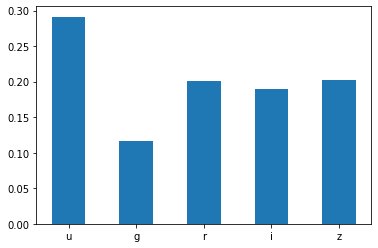

In [102]:
plt.bar(np.arange(5), etc.feature_importances_, 0.5)
plt.xticks(np.arange(5), X.columns);

#### task 4: **calculate spectral indices & test importance**

hint:
`X_new = X.copy()`



In [103]:
X_new = X.copy()
X_new["u-g"] = X.u - X.g
X_new["u-r"] = X.u - X.r
X_new["u-z"] = X.u - X.z
X_new["i-z"] = X.i - X.z

X_new

,u,g,r,i,z,u-g,u-r,u-z,i-z
0,19.240999,17.525999,16.840000,16.613001,16.492001,1.715000,2.400999,2.748999,0.121000
1,19.732000,18.339001,17.767000,17.580000,17.481001,1.393000,1.965000,2.250999,0.098999
2,16.120001,15.232000,14.933000,14.845000,14.827000,0.888000,1.187001,1.293001,0.018001
3,18.995001,18.150999,17.877001,17.747000,17.766001,0.844002,1.118000,1.229000,-0.019001
4,19.032000,18.112000,17.848000,17.709999,17.712000,0.920000,1.184000,1.320000,-0.002001
...,...,...,...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,0.199999,0.584000,0.576000,-0.043999
863,26.433001,21.429001,20.261000,20.108000,20.073000,5.004000,6.172001,6.360001,0.035000
864,20.535999,20.200001,20.292999,19.910000,19.726000,0.335999,0.243000,0.809999,0.184000
865,20.627001,20.583000,20.270000,20.229000,20.190001,0.044001,0.357000,0.437000,0.039000


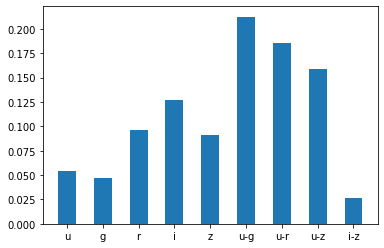

In [104]:
etc = ExtraTreesClassifier(random_state=42).fit(X_new,y)
plt.bar(np.arange(9), etc.feature_importances_, 0.5)
plt.xticks(np.arange(9), X_new.columns);

#### task 5: **test score if only *u-r* or *i-z* spectral indices are used**

hint: for single columns use `X_new[["u-r"]]`

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_new[["u-r"]], y, stratify=y, random_state=420)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9539170506912442

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_new[["i-z"]], y, stratify=y, random_state=420)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7557603686635944

In [107]:
sum(data.target == "star") / data.target.size

0.7554786620530565

#### task 6: **create dummy column & test importance**

hint:
```
X_new2 = X.copy()
X_new2["dummy"] = np.random.randint(10, size=X.r.size)
```

In [108]:
X_new2 = X.copy()

X_new2["dummy"] = np.random.normal(0, 1, size=X.r.size)
X_new2["dummy2"] = np.ones_like(X.r)

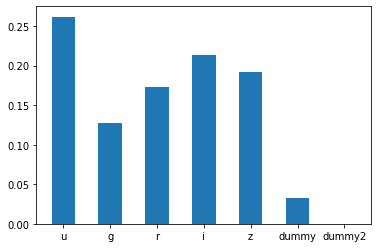

In [109]:
etc = ExtraTreesClassifier().fit(X_new2,y)
plt.bar(np.arange(7), etc.feature_importances_, 0.5)
plt.xticks(np.arange(7), X_new2.columns);

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_new2[["dummy"]], y, stratify=y, random_state=420)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7557603686635944

### [**Principal component analysis**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

<img src="https://programmathically.com/wp-content/uploads/2021/08/pca-2-dimensions-1024x644.png" width=600pt></img>

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)

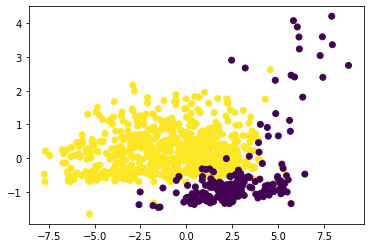

In [116]:
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y)

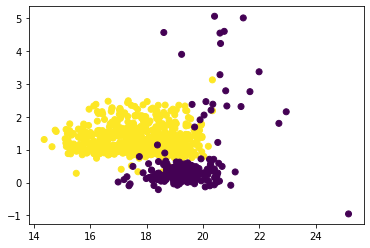

In [117]:
plt.scatter(X.g, X.u-X.g, c=y)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, stratify=y, random_state=420)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9539170506912442

### task 7: **integrate `PCA(n_components=2)` into our pipeline**

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420)

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      SVC(kernel="linear"))
                    #   DecisionTreeClassifier(random_state=420))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9539170506912442

## [**Cross-validation**](https://scikit-learn.org/stable/modules/cross_validation.html)

<img src="https://miro.medium.com/max/1400/1*AAwIlHM8TpAVe4l2FihNUQ.png" width=800pt></img>

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420)

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      SVC(kernel="linear"))
                    #   DecisionTreeClassifier(random_state=420))

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9539170506912442

### task 8: **use several different random states when splitting data & get average score**

hint: you can use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

In [128]:
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=i)

    model.fit(X_train, y_train)

    scores.append(model.score(X_test, y_test))

scores

[0.9354838709677419,
 0.9493087557603687,
 0.9539170506912442,
 0.9585253456221198,
 0.9447004608294931,
 0.9585253456221198,
 0.9308755760368663,
 0.9539170506912442,
 0.9400921658986175,
 0.9354838709677419]

In [129]:
np.mean(scores), np.std(scores)

(0.9460829493087557, 0.009677419354838708)

In [130]:
from sklearn.model_selection import cross_validate

res = cross_validate(model, X, y, cv=10)

print(res)

{'fit_time': array([0.0238657 , 0.02246332, 0.02140427, 0.02047563, 0.02082872,
       0.02066994, 0.03326559, 0.02011371, 0.02103639, 0.02055836]), 'score_time': array([0.00373697, 0.00472617, 0.00361538, 0.00360012, 0.00449729,
       0.00521135, 0.00397229, 0.00427651, 0.00404644, 0.00764608]), 'test_score': array([0.95402299, 0.94252874, 0.96551724, 0.94252874, 0.94252874,
       0.95402299, 0.95402299, 0.93023256, 0.96511628, 0.97674419])}


In [131]:
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9527265437048917, 0.013103290409293528)

## **Tuning hyperparameters**

In [134]:
# SVC?
DecisionTreeClassifier?

#### task 9: **find SVC hyperparameters with best test score**

In [136]:
def classify(X, y, classifier):
    model = make_pipeline(PCA(n_components=3),
                          StandardScaler(),
                          classifier)

    res = cross_validate(model, X, y, cv=10)
    print(np.mean(res["test_score"]))

In [137]:
classify(X, y, SVC(kernel="linear"))

0.9527265437048917


In [138]:
classify(X, y, SVC(kernel="linear", C=10))

0.9481154771451484


In [139]:
classify(X, y, SVC(kernel="linear", C=0.1))

0.9561881849772786


In [140]:
classify(X, y, SVC(kernel="poly", degree=1))

0.9550387596899224


In [141]:
classify(X, y, SVC(kernel="rbf", C=1))

0.9884656508954827


### **Grid-search + crossvalidation**

In [144]:
from sklearn.model_selection import GridSearchCV

In [153]:
C = [0.01, 0.1, 1, 10]
kernel = ["linear", "poly", "rbf"]

params = {"C" : C,
          "kernel" : kernel}

model = GridSearchCV(SVC(), params, cv=10, n_jobs=4)
model.fit(X, y)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf']})

In [158]:
model.cv_results_

{'mean_fit_time': array([ 0.0298147 ,  0.45366888,  0.06967466,  0.03261931,  2.57811286,
         0.05565796,  0.03600531,  7.75777194,  0.03015213,  0.06542313,
        10.30636275,  0.02380219]),
 'std_fit_time': array([1.05554098e-02, 1.13476086e-01, 1.02128629e-02, 3.90200323e-03,
        5.47951881e-01, 7.59203626e-03, 5.02592163e-03, 2.93773077e+00,
        4.68595416e-03, 1.97454053e-02, 5.31825923e+00, 6.10626614e-03]),
 'mean_score_time': array([0.00877495, 0.00531535, 0.01674664, 0.00785882, 0.00751235,
        0.01260271, 0.00654867, 0.00521111, 0.00918403, 0.00859876,
        0.00408461, 0.00638976]),
 'std_score_time': array([0.00701229, 0.00327485, 0.00516464, 0.00485944, 0.0039998 ,
        0.00246673, 0.00376755, 0.00322015, 0.00452567, 0.0040568 ,
        0.00291156, 0.00373154]),
 'param_C': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, F

In [159]:
pars, score = model.cv_results_["params"], model.cv_results_["mean_test_score"]

indices = np.argsort(score)

for i in indices:
    print(pars[i], score[i].round(3))

{'C': 0.01, 'kernel': 'rbf'} 0.755
{'C': 0.01, 'kernel': 'linear'} 0.887
{'C': 0.1, 'kernel': 'linear'} 0.937
{'C': 1, 'kernel': 'linear'} 0.946
{'C': 10, 'kernel': 'linear'} 0.948
{'C': 0.1, 'kernel': 'rbf'} 0.949
{'C': 0.01, 'kernel': 'poly'} 0.964
{'C': 1, 'kernel': 'rbf'} 0.971
{'C': 0.1, 'kernel': 'poly'} 0.971
{'C': 1, 'kernel': 'poly'} 0.973
{'C': 10, 'kernel': 'poly'} 0.978
{'C': 10, 'kernel': 'rbf'} 0.98


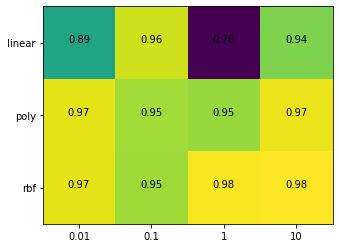

In [166]:
res = model.cv_results_
plt.imshow(res["mean_test_score"].reshape(3,4))
n = 0
for i,k in enumerate(kernel):
    for j,c in enumerate(C):
        plt.text(j,i,"{0:.2f}".format(res["mean_test_score"][n]), ha="center")
        n += 1

plt.xticks(np.arange(len(params["C"])), params["C"]);
plt.yticks(np.arange(len(params["kernel"])), params["kernel"]);

In [170]:
model.best_estimator_

SVC(C=10)

## **Classifier comparison**

In [177]:
from sklearn.neural_network import MLPClassifier # multi-layer perceptron classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [178]:
classifiers = [MLPClassifier(max_iter=1000),
               GaussianNB(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               SVC(kernel="rbf", C=10)]

for classifier in classifiers:
    classify(X, y, classifier)

0.9861668003207698
0.8950013365410319
0.960772520716386
0.9850173750334136
0.9838679497460572


In [180]:
clf = MLPClassifier(max_iter=1000)
params = {"hidden_layer_sizes" : [5, 10, 50, 100],
          "activation" : ["identity", "logistic", "tanh", "relu"]}#,
          #"solver" : ["sgd", "adam"]}

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      GridSearchCV(clf, params, cv=5, n_jobs=4))

model.fit(X, y)

Pipeline(steps=[('pca', PCA(n_components=3)),
                ('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000),
                              n_jobs=4,
                              param_grid={'activation': ['identity', 'logistic',
                                                         'tanh', 'relu'],
                                          'hidden_layer_sizes': [5, 10, 50,
                                                                 100]}))])

In [176]:
model.best_estimator_, model.best_score_

(MLPClassifier(activation='tanh', hidden_layer_sizes=10, max_iter=1000),
 0.9481230483024383)

In [ ]:
%time MLPClassifier(activation="tanh", hidden_layer_sizes=10, max_iter=1000).fit(X_train, y_train)

CPU times: user 1.13 s, sys: 66.3 ms, total: 1.2 s
Wall time: 1.14 s


MLPClassifier(activation='tanh', hidden_layer_sizes=10, max_iter=1000)

In [ ]:
%time SVC(C=10).fit(X_train, y_train)

CPU times: user 11.5 ms, sys: 789 µs, total: 12.3 ms
Wall time: 12.8 ms


SVC(C=10)

## **Ensemble methods**

In [183]:
from sklearn.ensemble import RandomForestClassifier

In [184]:
model = RandomForestClassifier()

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9653568564554933, 0.017980605272178162)

In [185]:
from sklearn.ensemble import StackingClassifier

In [186]:
classifiers = [("DT1", DecisionTreeClassifier(random_state=1)),
               ("DT2", DecisionTreeClassifier(random_state=2))
               ("DT3", DecisionTreeClassifier(random_state=3))
               ("DT3", DecisionTreeClassifier(random_state=4))]

model = StackingClassifier(classifiers)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

TypeError: ignored

In [187]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("RFC", RandomForestClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

model = StackingClassifier(classifiers)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9780673616680031, 0.013099254486727276)

In [188]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      StackingClassifier(classifiers))

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9861801657310878, 0.006887843167932408)

## **Performance evaluation**

### task 10: **try [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)**

In [189]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [197]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

model = make_pipeline(PCA(n_components=3),
                      StandardScaler(),
                      MLPClassifier(max_iter=1000, random_state=42))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.897     0.981     0.937        53
           1      0.994     0.963     0.978       164

    accuracy                          0.968       217
   macro avg      0.945     0.972     0.958       217
weighted avg      0.970     0.968     0.968       217



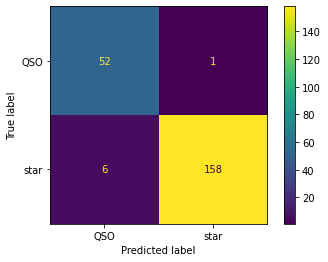

In [198]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

## **Conclusion**

In [199]:
classifiers = [("MLP", MLPClassifier(max_iter=100, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

# train the model
clf = StackingClassifier(classifiers)

model = make_pipeline(StandardScaler(),
                      clf)

model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('MLP',
                                                 MLPClassifier(max_iter=1000,
                                                               random_state=42)),
                                                ('Bayes', GaussianNB()),
                                                ('DTC',
                                                 DecisionTreeClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVC', SVC(C=10))]))])

In [ ]:
model.predict(X_test)

## **Model inference**

### task 13: **pick an object from SDSS and classify it**

In [ ]:
u = 15.914
g = 15.500
r = 16.2
i = 16.5
z = 17.1

X_real = pd.DataFrame(np.array([[u,g,r,i,z]]), columns=["u","g","r","i","z"])

X_real

In [ ]:
pred = model.predict(X_real)

le.inverse_transform(pred)